In [1]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1028"

import torch
torch.cuda.empty_cache()

In [2]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()
"""
Issues Encountered:
cant have negative numbers in multidimensional arrays
cant have camel case words
cant have float attributes
cant change column types of udf without restarting db and deleting
query takes infinitley long when UDF in 
inner join does not work
"""

Note: you may need to restart the kernel to use updated packages.


'\nIssues Encountered:\ncant have negative numbers in multidimensional arrays\ncant have camel case words\ncant have float attributes\ncant change column types of udf without restarting db and deleting\nquery takes infinitley long when UDF in \ninner join does not work\n'

In [3]:
### Set up Yolo UDF
cursor.query("""
            CREATE UDF IF NOT EXISTS Yolo
            TYPE  ultralytics
            'model' 'yolov8m.pt';
    """).df() 

,0
0,"UDF Yolo already exists, nothing added."


In [4]:
### Set up Monodepth UDF
cursor.query(""" 
            CREATE UDF IF NOT EXISTS MonodepthDetection
            IMPL'/home/youse/apperception/eva/udfs/monodepth_detection.py';
    """).df()

CUDA is available.
 > 0: Tesla T4
   1: Tesla T4


/home/youse/miniconda3/envs/apperception/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/youse/miniconda3/envs/apperception/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


,0
0,UDF MonodepthDetection successfully added to t...


In [5]:
### Set up Location UDF
cursor.query(""" 
            CREATE UDF IF NOT EXISTS LocationDetection
            IMPL'/home/youse/apperception/eva/udfs/location_detection.py';
    """).df()

,0
0,UDF LocationDetection successfully added to th...


In [6]:
### Set up Intersection Query UDF
cursor.query(""" 
            CREATE UDF IF NOT EXISTS IntersectionQuery
            IMPL'/home/youse/apperception/eva/udfs/intersection_query.py';
    """).df()

,0
0,UDF IntersectionQuery successfully added to th...


In [7]:
### Set up SameVideo UDF
cursor.query(""" 
            CREATE UDF IF NOT EXISTS SameVideo
            IMPL'/home/youse/apperception/eva/udfs/same_video.py';
    """).df()

,0
0,UDF SameVideo successfully added to the database.


In [8]:
# Certain attributes are made TEXTs due to issues Eva has with negative numbers
cursor.query("DROP TABLE IF EXISTS CameraConfigs;").df()
cursor.create_table("CameraConfigs", if_not_exists=True, columns="""
                cameraid TEXT(15),
                framenum INTEGER,
                cameratranslation NDARRAY FLOAT32(ANYDIM),
                camerarotation TEXT(100),
                cameraintrinsic NDARRAY FLOAT32(ANYDIM),
                egoheading TEXT(15),
                filename TEXT(30)
            """).df()


""


In [9]:
### Load Data
from apperception.database import database
import pandas as pd

cursor.query("DROP TABLE IF EXISTS ObjectDetectionVideos;").df()

with open("scene-names.txt", 'r') as f:
    for sceneNumber in f.readlines():
        sceneNumber = sceneNumber.strip()
        # Load videos
        video_name = f"boston-seaport-scene-{sceneNumber}-CAM_FRONT.mp4"
        scene = f"scene-{sceneNumber}-CAM_FRONT"
        video_path = "/data/processed/full-dataset/trainval/videos/"
        cursor.load(file_regex=video_path + video_name, format="VIDEO", table_name='ObjectDetectionVideos').df()

        # Add camera configs
        result = database.execute(f"SELECT cameraId, frameNum, cameraTranslation, cameraRotation, cameraIntrinsic, egoHeading, filename FROM Cameras WHERE cameraId = '{scene}'")
        df = pd.DataFrame()
        for r in result:
            cameraId, frameNum, cameraTranslation, cameraRotation, cameraIntrinsic, egoHeading, filename = r
            cameraTranslation = list(cameraTranslation)
            # FrameNums in Eva are zero-indexed, so we subtract one before inserting
            cursor.query(f"""INSERT INTO CameraConfigs (cameraid, framenum, cameratranslation, camerarotation, cameraintrinsic, egoheading, filename) VALUES
                                        ('{cameraId}', {frameNum - 1}, {cameraTranslation}, '{cameraRotation}', {cameraIntrinsic}, '{egoHeading}', '{filename}');""").df()

        

In [ ]:
## Create YOLO 
cursor.query("""
        CREATE TABLE
        YoloVideos AS 
        SELECT *, Yolo(data) FROM ObjectDetectionVideos;
""").df()

In [10]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)


# cursor.query("""
#     SELECT framenum, id, name, cameraid, cameratranslation
#     FROM ObjectDetectionVideos JOIN CameraConfigs ON (id = framenum AND SameVideo(name, cameraid).issame)
# """).df()

In [55]:
### Run query
res = cursor.query("""
            SELECT framenum, id, cameraid, filename, name, egoheading, Yolo(data).labels, IntersectionQuery(LocationDetection(Yolo(data), MonodepthDetection(data).depth, cameratranslation, camerarotation, cameraintrinsic)) 
                FROM ObjectDetectionVideos JOIN CameraConfigs ON (id = framenum AND SameVideo(name, cameraid).issame)
                WHERE IntersectionQuery(LocationDetection(Yolo(data), MonodepthDetection(data).depth, cameratranslation, camerarotation, cameraintrinsic)).queryresult = 1
""").df()

/home/youse/miniconda3/envs/apperception/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/youse/miniconda3/envs/apperception/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/youse/miniconda3/envs/apperception/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/youse/miniconda3/envs/apperception/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments 

In [56]:
import numpy as np
np.array([True, True]).any()

True

In [57]:
pd.set_option('display.max_colwidth', None)
res[res['intersectionquery.queryresult'] == True]

,cameraconfigs.framenum,objectdetectionvideos.id,cameraconfigs.cameraid,cameraconfigs.filename,objectdetectionvideos.name,cameraconfigs.egoheading,yolo.labels,intersectionquery.queryresult
0,206.0,206.0,scene-0513-CAM_FRONT,sweeps/CAM_FRONT/n008-2018-08-28-13-40-50-0400__CAM_FRONT__1535478900162404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0513-CAM_FRONT.mp4,137.4509,"[car, truck, traffic light]",True
1,37.0,37.0,scene-0523-CAM_FRONT,samples/CAM_FRONT/n008-2018-08-30-10-33-52-0400__CAM_FRONT__1535639717162404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0523-CAM_FRONT.mp4,-124.02617,"[car, car, car, car, car, car, car, car, truck]",True
2,90.0,90.0,scene-0513-CAM_FRONT,sweeps/CAM_FRONT/n008-2018-08-28-13-40-50-0400__CAM_FRONT__1535478898512404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0513-CAM_FRONT.mp4,170.2291,"[truck, truck, car, car]",True
3,143.0,143.0,scene-0523-CAM_FRONT,sweeps/CAM_FRONT/n008-2018-08-30-10-33-52-0400__CAM_FRONT__1535639718662404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0523-CAM_FRONT.mp4,-128.56935,"[car, dog, car, car]",True
4,143.0,143.0,scene-0513-CAM_FRONT,samples/CAM_FRONT/n008-2018-08-28-13-40-50-0400__CAM_FRONT__1535478899262404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0513-CAM_FRONT.mp4,157.54471,"[truck, car, car]",True
...,...,...,...,...,...,...,...,...
80,173.0,173.0,scene-0523-CAM_FRONT,samples/CAM_FRONT/n008-2018-08-30-10-33-52-0400__CAM_FRONT__1535639719112404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0523-CAM_FRONT.mp4,-130.02766,"[car, car, truck, car]",True
81,173.0,173.0,scene-0523-CAM_FRONT,samples/CAM_FRONT/n008-2018-08-30-10-33-52-0400__CAM_FRONT__1535639719112404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0523-CAM_FRONT.mp4,-130.02766,"[car, car, car, truck, car, car]",True
82,173.0,173.0,scene-0523-CAM_FRONT,samples/CAM_FRONT/n008-2018-08-30-10-33-52-0400__CAM_FRONT__1535639719112404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0523-CAM_FRONT.mp4,-130.02766,"[car, car, car, truck]",True
83,173.0,173.0,scene-0523-CAM_FRONT,samples/CAM_FRONT/n008-2018-08-30-10-33-52-0400__CAM_FRONT__1535639719112404.jpg,/data/processed/full-dataset/trainval/videos/boston-seaport-scene-0523-CAM_FRONT.mp4,-130.02766,"[car, car, car, car, car, car, car, fire hydrant, car, car]",True


cameraconfigs.framenum                                                                                          200.0
objectdetectionvideos.id                                                                                        200.0
cameraconfigs.cameraid                                                                           scene-0513-CAM_FRONT
cameraconfigs.filename                sweeps/CAM_FRONT/n008-2018-08-28-13-40-50-0400__CAM_FRONT__1535478900112404.jpg
objectdetectionvideos.name       /data/processed/full-dataset/trainval/videos/boston-seaport-scene-0513-CAM_FRONT.mp4
cameraconfigs.egoheading                                                                                     138.6163
yolo.labels                                                                                 [bus, car, car, car, car]
intersectionquery.queryresult                                                                                    True
Name: 15, dtype: object

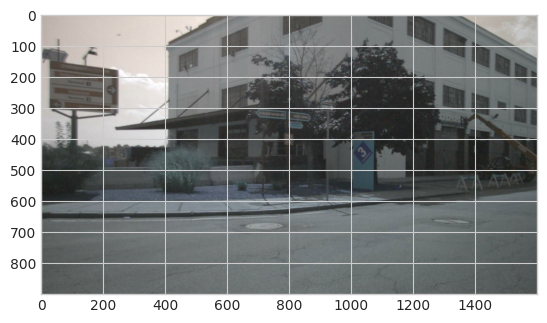

In [59]:
import cv2
import matplotlib.pyplot as plt


def displayFrame(row):
    prefix = "/data/raw/full-dataset/trainval/"
    # itemIds = ['scene-0757-CAM_FRONT_obj_44', 'scene-0757-CAM_FRONT_obj_23']
    frame_im = cv2.imread(prefix + row['cameraconfigs.filename'])
    plt.imshow(frame_im)


onlyTrue = res[res['intersectionquery.queryresult'] == True]
# res.apply(displayFrame, axis=1)
displayFrame(onlyTrue.iloc[15])
onlyTrue.iloc[15]